## Prepare the environment and data

In [476]:
import findspark
findspark.init()

In [477]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Final Project") \
     .getOrCreate()
sc = spark.sparkContext      # get the context
sc

<SparkContext master=yarn appName=Final Project>

In [478]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     


In [479]:
features = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/fma_dataset.csv")

In [480]:
tracks = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/tracks.csv")

In [481]:
#Combine two csv file by tracks_id column
Join_table = features.join(tracks["track_id","genre_top"], features.feature == tracks.track_id)

In [482]:
#convert the type of track_id column into integer
from pyspark.sql.types import *
Join_table = Join_table.withColumn("track_id", Join_table["track_id"].cast(IntegerType()))

In [483]:
#order by track_id column
from pyspark.sql.functions import col
Join_table = Join_table.orderBy(Join_table.track_id)

In [484]:
#delete duplicate column
Join_table = Join_table.drop('feature')

#### .printSchema()

There are 520 columns in the following dataframe. 
The first 518 columns are features extracted by LibROSA, which is a python package for music and audio analysis. 
The last two columns are respectively the identity column "track_id" and the target variable "genre_top".

In [485]:
#Join_table.printSchema()

Create a TempView and filter out distinct values of target variables:

Now we have four categories: album, live performance, single tracks and radio program.

In [486]:
Join_table.createOrReplaceTempView("Join_table")

#### cleaned_df
This dataframe now has an identity column, a label column and 518 feature columns for feature engineering and modeling.

In [487]:
cleaned_df = spark.sql("select * from Join_table where genre_top in ('Experimental','Electronic','Rock','Instrumental','Pop','Folk','Hip-Hop','International','Jazz','Classical','Country','Spoken','Blues') ")

In [488]:
cleaned_df.count() # The No. of row of the dataframe

11105

## Exploratory data analysis

### 1. Check the balance of the target variable

In [489]:
import pyspark.sql.functions as F
from pyspark.sql.functions import bround
check_balance = cleaned_df.groupBy("genre_top").count()
check_balance = check_balance.withColumn("Percentage",bround(F.col("count")/11105,2))

In [ ]:
check_balance.show()

The data is highly imbalanced, The "Album" label takes up 90% among all labels and all other three label types only take up 10%.

### 2. Check the collinearity of features

#### The features we selected for supervised learning:
 
1. chroma_cens1
2. chroma_cqt85
3. chroma_stft169
4. mfcc253
5. spectral_bandwidth400
6. spectral_centroid407
7. spectral_contrast414
8. spectral_rolloff463
9. tonnetz470
10. zcr512

In [ ]:
features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'spectral_rolloff463', 'tonnetz470', 
           'zcr512']

myGraph=cleaned_df[features]
for col in features:
    myGraph = myGraph.withColumn(col,myGraph[col].cast(DoubleType()))

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=features, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(myGraph).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray()

In [ ]:
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(111)
ax.set_title("Correlation Matrix for Selected Features")
ax.set_xticklabels(features,minor=True)
ax.set_yticklabels(features,minor=True)
for i in range(len(corrmatrix)):
    for j in range(len(corrmatrix[i])):
        text = ax.text(j,i, np.round(corrmatrix[i, j],2),ha="center", va="center", color="black")
cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
fig.colorbar(cax)
plt.show()

Fome the above correlation plot, we can conclude that feature 'spectral_centroid407' and 'spectral_rolloff463' have a relatively strong and positive relationship, while others are weakly or not correlated.

## Supervised Learning Models

Perform some data cleaning and feature processing for training models.

In [491]:
new_df1 = cleaned_df

In [492]:
def convert_type(line):
    return float(line)

In [493]:
convert_udf = udf(convert_type, FloatType())
new_df2 = new_df1.withColumn("chroma_cens1", convert_udf(new_df1.chroma_cens1)).withColumnRenamed("chroma_cens1", "chroma_cens1")
new_df2 = new_df2.withColumn("chroma_cqt85", convert_udf(new_df1.chroma_cqt85)).withColumnRenamed("chroma_cqt85", "chroma_cqt85")
new_df2 = new_df2.withColumn("chroma_stft169", convert_udf(new_df1.chroma_stft169)).withColumnRenamed("chroma_stft169", "chroma_stft169")
new_df2 = new_df2.withColumn("mfcc253", convert_udf(new_df1.mfcc253)).withColumnRenamed("mfcc253", "mfcc253")
new_df2 = new_df2.withColumn("spectral_bandwidth400", convert_udf(new_df1.spectral_bandwidth400)).withColumnRenamed("spectral_bandwidth400", "spectral_bandwidth400")
new_df2 = new_df2.withColumn("spectral_centroid407", convert_udf(new_df1.spectral_centroid407)).withColumnRenamed("spectral_centroid407", "spectral_centroid407")
new_df2 = new_df2.withColumn("spectral_contrast414", convert_udf(new_df1.spectral_contrast414)).withColumnRenamed("spectral_contrast414", "spectral_contrast414")
new_df2 = new_df2.withColumn("tonnetz470", convert_udf(new_df1.tonnetz470)).withColumnRenamed("tonnetz470", "tonnetz470")
new_df2 = new_df2.withColumn("zcr512", convert_udf(new_df1.zcr512)).withColumnRenamed("zcr512", "zcr512")


In [494]:
new_df2 = new_df2.na.drop()

In [495]:
new_df3 = new_df2.where((new_df2['genre_top'] == 'International') | (new_df2['genre_top'] == 'Instrumental') 
                        | (new_df2['genre_top'] == 'Rock')
                        | (new_df2['genre_top'] == 'Jazz')  | (new_df2['genre_top'] == 'Pop') 
                        | (new_df2['genre_top'] == 'Folk') | (new_df2['genre_top'] == 'Classical') 
                        | (new_df2['genre_top'] == 'Blues')  | (new_df2['genre_top'] == 'Electronic') 
                        | (new_df2['genre_top'] == 'Experimental') | (new_df2['genre_top'] == 'Spoken')
                        | (new_df2['genre_top'] == 'Country')  | (new_df2['genre_top'] == 'Hip-Hop'))


In [496]:
cols = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512', 'genre_top']
new_df3 = new_df3[cols]

### Logistic Regression

In [497]:
# Create a feature vector by combining all features together using the vectorAssembler method.

vectorAssembler_features = VectorAssembler(inputCols = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512'], outputCol = 'features')
StringIndexer_type = StringIndexer(inputCol = 'genre_top', outputCol = 'label')

In [498]:
StringIndexer_type = StringIndexer(inputCol = 'genre_top', outputCol = 'label')

In [499]:
from pyspark.sql.functions import bround
new_df4 = new_df3.groupBy("genre_top").count()
new_df5 = new_df4.withColumn("Weight",bround(11105/F.col("count"),2))

In [501]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
pipeline = Pipeline(stages=[vectorAssembler_features, StringIndexer_type])
pipelineFit = pipeline.fit(new_df6)
dataset = pipelineFit.transform(new_df6)
train, test = dataset.randomSplit([0.7, 0.3])
model = lr.fit(train)
predictions = model.transform(test)

In [506]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.2699908786865309


The accuracy of the logistic regression model is only 0.27 and the performance is very bad, so we train an OneVsRest Logistic Regression model. The idea for OneVsRest Logistic Regression is that for each class, there is a binary classifier: this class or the rest of the class. When doing a multi class classification, choose the class with the highest probability. 

### OneVsRest Logistic Regression

In [507]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1e-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

In [508]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.34356947400425664


In [509]:
test_array = [int(row.label) for row in test.collect()]
pred_array = [int(row.prediction) for row in predictions.collect()]
cm = confusion_matrix(test_array, pred_array)

Text(0.5, 1.0, 'Confusion Matrix')

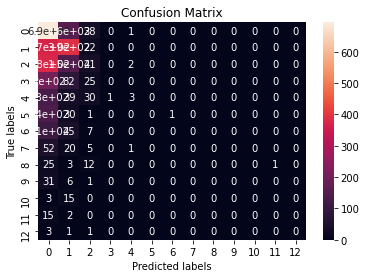

In [512]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')


The accuracy of the OneVsRest Logistic Regression model is 0.344, and the performance is better than logistic regression but still not ideal, so we train a decision tree model to see how it goes.  

### Decision Tree

In [513]:
from pyspark.ml.classification import DecisionTreeClassifier


In [515]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.3706293706293706


In [516]:
test_array = [int(row.label) for row in test.collect()]
pred_array = [int(row.prediction) for row in predictions.collect()]
cm = confusion_matrix(test_array, pred_array)

Text(0.5, 1.0, 'Confusion Matrix')

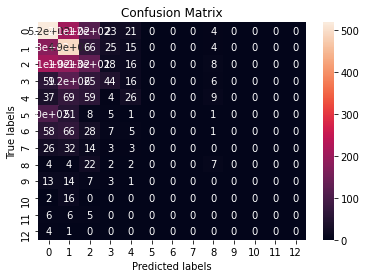

In [519]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

The accuracy of the decision tree model is 0.37 and the performance is the best among all three supervised learning models we have trained. 